### In this case study we will consider several real-life situations <br>when something goes wrong in your ML day-to-day routines <br>and will find out how these can be dealed with

In [31]:
# conda create -n ds-course-lesson python=3.8 nb_conda
# conda activate ds-course-lesson
# !pip install pandas numpy scikit-learn plotly

# however, in real life, track package versions, use mature approaches, 
# like Docker + requirements files + poetry package manager (or similar)
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.metrics import (
    mean_absolute_percentage_error as mape, 
    mean_absolute_error as mae
)
from sklearn.pipeline import Pipeline
import plotly.express as px

---
### Case 1: Know your ML model specifics

**Task: given time-series data (several time-series), predict target sales at time (t)**

- X: Features
    - time axis: [2020-01-01 - 2020-12-31]
    - id - time-series id
    - other features (...)
- Target: sales quantity, [0, inf)

For proof-of-concept you decide to use **RandomForest regressor as a forecaster**, as 
- it's robust to overfitting 
- training parallelizes well 
- it's robust to feature magnitude
- overall is a strong baseline for tabular data (similar to boosting)

In [32]:
# make synthetic data

ts_ids = list(range(1, 100)) # time series' ids
time_bounds = pd.date_range(start='2020-01-01', end='2020-12-31', freq='D') # time axis index
steps = len(time_bounds)

idx_names = ['ts_id', 'date']
idx = pd.MultiIndex.from_product([ts_ids, time_bounds], names=idx_names)
df = pd.DataFrame(index=idx)
# create y
sampler = np.random.RandomState(42)

target = []
# generate fake data
for ts in ts_ids:
    y = np.arange(steps, dtype=np.float32) + 1
    y *= (1 + sampler.randn(steps) * 0.03)
    target.extend(y)

target_col = 'target'
df[target_col] = target
df[f'f_1'] = df['target'] * (1 + sampler.randn(len(df)) * 0.1)
df[f'f_2_{target_col}_lag1'] = df.groupby(level=0)[target_col].shift().fillna(0)
df[f'f_2_{target_col}_lag2'] = df.groupby(level=0)[target_col].shift(2).fillna(0)
df[f'f_2_{target_col}_lag3'] = df.groupby(level=0)[target_col].shift(3).fillna(0)

print(df.drop(target_col, axis=1).corrwith(df[target_col]))
df = df.reset_index()

df

f_1                0.980600
f_2_target_lag1    0.996382
f_2_target_lag2    0.996421
f_2_target_lag3    0.996442
dtype: float64


,ts_id,date,target,f_1,f_2_target_lag1,f_2_target_lag2,f_2_target_lag3
0,1,2020-01-01,1.014901,0.986695,0.000000,0.000000,0.000000
1,1,2020-01-02,1.991704,1.888548,1.014901,0.000000,0.000000
2,1,2020-01-03,3.058292,3.367743,1.991704,1.014901,0.000000
3,1,2020-01-04,4.182764,3.990824,3.058292,1.991704,1.014901
4,1,2020-01-05,4.964877,5.182172,4.182764,3.058292,1.991704
...,...,...,...,...,...,...,...
36229,99,2020-12-27,364.318512,400.766844,360.598206,354.426117,340.337189
36230,99,2020-12-28,361.448914,324.475529,364.318512,360.598206,354.426117
36231,99,2020-12-29,356.430145,407.530818,361.448914,364.318512,360.598206
36232,99,2020-12-30,375.081238,337.095593,356.430145,361.448914,364.318512


In [33]:
# check baseline - good, then, our model has to be even better
baseline_col = 'f_2_target_lag1'
target_col = 'target'

f = mape # choose evaluation metric

print(f'{f.__name__}, baseline: {f(df[target_col], df[baseline_col]):.3f}')

# everything looks fine, clear dependencies are visible for sample timeseries
px.line(df.set_index(idx_names).unstack(level=0).iloc[:, :2]['target'])

mean_absolute_percentage_error, baseline: 0.043


In [34]:
# create train/val split
val_start = '2020-09-01'
idx_train = df['date'] < val_start
idx_val = df['date'] >= val_start

df_train, df_val = df[idx_train].copy(), df[idx_val].copy()

# check baseline - still good on both splits
print(
    f'{f.__name__}, baseline (train): '
    f'{f(df_train[target_col], df_train[baseline_col]):.3f}'
)
print(
    f'{f.__name__}, baseline (valid): '
    f'{f(df_val[target_col], df_val[baseline_col]):.3f}'
)

mean_absolute_percentage_error, baseline (train): 0.047
mean_absolute_percentage_error, baseline (valid): 0.034


In [35]:
model = RandomForestRegressor(
    # choose your favorite params via validation
    n_estimators=20, 
    random_state=42
) 
X_train, y_train = df_train.filter(regex='f_'), df_train[target_col]
X_val, y_val = df_val.filter(regex='f_'), df_val[target_col]

model.fit(X_train, y_train)
prediction_train = model.predict(X_train)
prediction_val = model.predict(X_val)

# check model performance
print(f'{f.__name__}, model (train): {f(df_train[target_col], prediction_train):.3f}')
print(f'{f.__name__}, model (valid) - oops: {f(df_val[target_col], prediction_val):.3f}')

mean_absolute_percentage_error, model (train): 0.011
mean_absolute_percentage_error, model (valid) - oops: 0.168


#### Why did this happen?


RandomForest regressor ensemble works on **simple averaging techniques**
- however, maximum observed target on train `y_train_max` <br> is the **upper limit of each individual tree prediction** 
- thus, averaging it gives **at most** `y_train_max` prediction for val/test set

<img src='https://i.imgflip.com/5vss3b.jpg' width="200" align='left'/>

In [36]:
# see max value on pred: max_pred <= max_target_train
stats = pd.DataFrame(
    [
        pd.Series(prediction_val).describe(), 
        pd.Series(y_val).describe(),
        pd.Series(y_train.values).describe()
    ], 
).T

stats.columns = ['pred', 'target', 'train']
stats

,pred,target,train
count,12078.000000,12078.000000,24156.000000
mean,250.981457,305.451660,122.473564
std,4.159685,36.449196,70.543449
min,232.414248,224.993637,0.929726
25%,248.073405,274.806168,61.658906
50%,253.760773,304.959747,122.250175
75%,253.760773,335.557533,183.459023
max,255.296838,402.234833,264.943542


#### How it can be avoided?
- change target from *raw scale* (sales quantity) to *relative scale* (`diff`s or `pct_change`s) - **get rid of trends**
- add proper lag features
- (OR) think about changing the **ML model type** (i.e. to ARIMA/Linear Regression etc.)
<br>with the ability to **extrapolate beyond training target range**

In [37]:
df = df[idx_names + [target_col] + ['f_2_target_lag1']].copy()
df['target_new'] = np.log(
    df[target_col] / df['f_2_target_lag1']
).replace([np.inf, -np.inf], 0).fillna(0)
df['f_target_new_lag1'] = df.groupby('ts_id')['target_new'].shift().fillna(0)
df['f_target_new_lag2'] = df.groupby('ts_id')['target_new'].shift(2).fillna(0)
df['f_target_new_lag3'] = df.groupby('ts_id')['target_new'].shift(3).fillna(0)

df.filter(regex='target_new').corr()

,target_new,f_target_new_lag1,f_target_new_lag2,f_target_new_lag3
target_new,1.000000,0.165753,0.289446,0.236516
f_target_new_lag1,0.165753,1.000000,0.166453,0.289835
f_target_new_lag2,0.289446,0.166453,1.000000,0.167375
f_target_new_lag3,0.236516,0.289835,0.167375,1.000000


In [38]:
# target is de-trended now
px.line(df.set_index(idx_names).unstack(level=0)['target_new'].iloc[50:, :3])

In [39]:
target_col = 'target_new'

# split data again, for new target
X_train, y_train = (
    df.filter(regex='f_target_new')[idx_train], 
    df.loc[idx_train, target_col]
)
X_val, y_val = (
    df.filter(regex='f_target_new')[idx_val], 
    df.loc[idx_val, target_col]
)

# create model and fit it on new features
model = RandomForestRegressor(n_estimators=20, random_state=42)
model.fit(X_train, y_train)
prediction_train = model.predict(X_train)
prediction_val = model.predict(X_val)
# return to initial scale
# https://www.wolframalpha.com/input/?i=solve+d+%3D+log%28s1%2Fs0%29+for+s1
y_pred_train = np.exp(prediction_train) * df_train['f_2_target_lag1'].values
y_pred_val = np.exp(prediction_val) * df_val['f_2_target_lag1'].values
# y_pred_train = df_train['f_2_target_lag1'].values * (1 + prediction_train)
# y_pred_val = df_val['f_2_target_lag1'].values * (1 + prediction_val)

# check model performance
print(f'{f.__name__}, model (train): {f(df_train["target"], y_pred_train):.3f}')
print(f'{f.__name__}, model (valid): {f(df_val["target"], y_pred_val):.3f}')

mean_absolute_percentage_error, model (train): 0.018
mean_absolute_percentage_error, model (valid): 0.032


In [40]:
# see max value on pred: max_pred <= max_target_train
stats = pd.DataFrame(
    [
        pd.Series(y_pred_val).describe(), 
        pd.Series(df.loc[idx_val, "target"]).describe(),
        pd.Series(y_pred_train).describe()
    ], 
).T

stats.columns = ['pred', 'target', 'train']
stats

,pred,target,train
count,12078.000000,12078.000000,24156.000000
mean,309.642932,305.451660,122.713648
std,36.624887,36.449196,70.903478
min,233.010267,224.993637,0.000000
25%,278.177966,274.806168,61.498131
50%,309.551736,304.959747,122.633960
75%,340.454269,335.557533,183.846652
max,402.491987,402.234833,256.773622


---
### Case 2 - What are the outliers ?

**Task: given time-series data (several time-series), predict target sales at time (t)**

- X: Features
    - time axis: [2020-01-01 - 2020-12-31]
    - id - time-series ID
    - price - product price at time (t)
- Target: sales quantity in units, [0, inf)

You try to predict sales change (%) at time (t) according to some features

In [41]:
ts_ids = list(range(1, 100)) # time series' IDs
time_bounds = pd.date_range(
    start='2020-01-01', 
    end='2020-12-31', 
    freq='D'
) # time axis index
steps = len(time_bounds)

idx_names = ['ts_id', 'date']
idx = pd.MultiIndex.from_product(
    [ts_ids, time_bounds], 
    names=idx_names
)
df = pd.DataFrame(index=idx)
# create y
sampler = np.random.RandomState(42)

target = []
# generate fake data
lambdas = 6 * (1 + sampler.randn(steps) * 0.05)
for ts, lam in zip(ts_ids, lambdas):
    y = sampler.poisson(lam=lam, size=steps)
    y = np.clip(y, 1, np.inf) # toy example, to prevent zero sales
    target.extend(y)

target_col = 'target'
df[target_col] = target
df['f_price'] = 1/df[target_col] * 1000 * np.abs(1 + sampler.randn(len(df))*0.2)
df['f_1'] = df[target_col] * (1 + sampler.randn(len(df))*0.1) # other useful feature
df = df.reset_index()
df.loc[df.ts_id == 6, 'f_price'] *= 20 # very expensive products
df['target_new'] = df.groupby('ts_id')['target'].pct_change().fillna(0).values
df['revenue'] = df[['target', 'f_price']].prod(axis=1)

df.head()

,ts_id,date,target,f_price,f_1,target_new,revenue
0,1,2020-01-01,4.0,323.020515,4.118187,0.000000,1292.082059
1,1,2020-01-02,9.0,82.447992,8.345632,1.250000,742.031932
2,1,2020-01-03,7.0,131.236599,6.786474,-0.222222,918.656196
3,1,2020-01-04,6.0,171.758381,6.335002,-0.142857,1030.550285
4,1,2020-01-05,13.0,75.148775,13.484212,1.166667,976.934080


In [42]:
# create train/val split
val_start = '2020-09-01'
idx_train = df['date'] < val_start
idx_val = df['date'] >= val_start

df_train, df_val = df[idx_train].copy(), df[idx_val].copy()

In [43]:
# check for outliers
px.histogram(df_train['f_price'])

<img src="http://memesmix.net/media/created/winv1v.jpg" width="200" align="center"/>

In [44]:
# we are smart enough to avoid hardcoding and use data-based thresholds
price_quantile = df_train['f_price'].quantile(0.98)
print(price_quantile)
df_train['f_price'] = df_train['f_price'].clip(0, price_quantile)

962.6190455601132


In [45]:
# check for outliers - now everything looks rather fine
px.histogram(df_train['f_price'])

In [46]:
# create simple pipeline
# we already know that linear regression need data scaling
pipeline = Pipeline(
    [
        ('scaler', StandardScaler()),
        ('regressor', LinearRegression())
    ]
)

# fit pipeline on train
X_train, y_train = df_train.filter(regex='f_'), df_train['target_new']
X_val, y_val = df_val.filter(regex='f_'), df_val['target_new']

pipeline.fit(X_train, y_train)
preds_train = pipeline.predict(X_train)
preds_val = pipeline.predict(X_val)

In [47]:
f = mae # choose evaluation metric, everything looks OK
print(f'{f.__name__}, train: {f(df_train["target_new"], preds_train):.3f}')
print(f'{f.__name__}, train: {f(df_val["target_new"], preds_val):.3f}')

mean_absolute_error, train: 0.534
mean_absolute_error, train: 0.529


In [48]:
# get val predictions at initial scale
preds_train_init = df_train.groupby('ts_id')[target_col].shift(1).fillna(1) * (1 + preds_train)
preds_val_init = df_val.groupby('ts_id')[target_col].shift(1).fillna(1) * (1 + preds_val)

print(f'train predictions domain: {(preds_train_init.min(), preds_train_init.max())}')
print(f'val   predictions domain: {(preds_val_init.min(), preds_val_init.max())}')
# oops, negative sales predictions, had to obtain [0, + inf) instead

train predictions domain: (0.15562554399992312, 45.58740758384135)
val   predictions domain: (-33.848358110792674, 38.71573891852583)


#### Why did this happen?

<div>
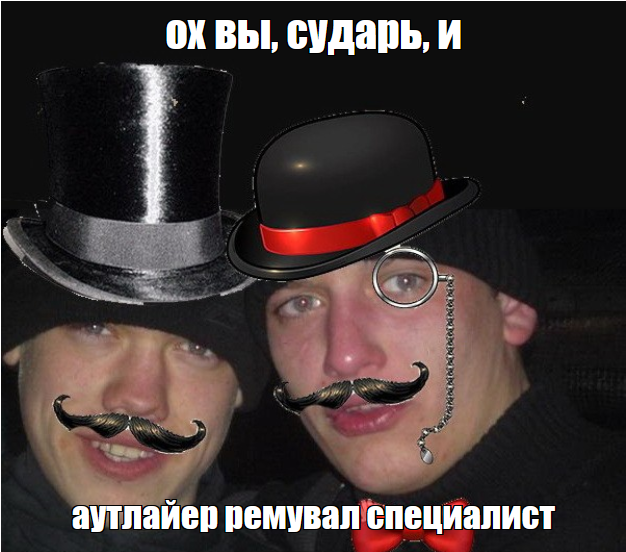
</div>

StandardScaler on `price` feature was trained on **data without outliers**

Given new data (expensive category's prices) on val dataset, `.transform()` scaled this data far outside learned range of `(-3, 3)` $\implies$ got unexpected model behavior and strange predictions of `% growth` outside of possible range [-1, +inf)

However, those data points was not outliers - we **cut off entire category #6 of expensive products!** 

From business side, we will got huge error and unexpected results on assorment subset that greatly drives revenue! 

In [49]:
stats = pd.DataFrame(
    {
        'train': pd.Series(preds_train).describe(),
        'val': df_val["target_new"].describe(),
        'pred': pd.Series(preds_val).describe(),
    }
)

stats

,train,val,pred
count,24156.000000,12078.000000,12078.000000
mean,0.263414,0.253638,0.260134
std,0.506328,1.019861,0.515164
min,-0.875410,-0.916667,-4.384836
25%,-0.092150,-0.333333,-0.091636
50%,0.224074,0.000000,0.229257
75%,0.579349,0.500000,0.573271
max,3.135600,12.000000,2.873273


In [50]:
revenue_share = df.groupby('ts_id').revenue.sum() / df['revenue'].sum()
revenue_share.sort_values(ascending=False) # id = 6 generates almost 1/6 of total revenue!

ts_id
6     0.168412
70    0.008669
34    0.008661
98    0.008636
44    0.008625
        ...   
83    0.008346
85    0.008338
51    0.008335
25    0.008333
1     0.008322
Name: revenue, Length: 99, dtype: float64

#### How it can be avoided?
- try to **always apply domain knowledge to distinguish between outliers and quantiles of real data**
- use stratified (by some category) outlier removal techniques to assure all data subsets are present in train data
- move from absolute features (price) to its derivatives (`log(price)`, `percentile(price)`, etc.)
- use more robust scalers, i.e. [RobustScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.RobustScaler.html) 
- clip your target predictions (either post-processing or within a model, i.e. apply [reLU layer](https://machinelearningmastery.com/rectified-linear-activation-function-for-deep-learning-neural-networks/) to get non-negative predictions)

### Case 3 - Dont judge too quickly

**Task: given calculated price elasticities for each product within category, define what the demand is (elastic or inelastic)**

- X: Columns (features and estimations)
    - id - time-series ID
    - sales - average sales per calculated period
    - revenue - average revenue per calculated period
    - elasticity - [estimated pointwise or arc elasticity of demand](https://en.wikipedia.org/wiki/Price_elasticity_of_demand)

In [51]:
N = 200

sales = sampler.poisson(lam=20., size=N)
prices = sales * 100 * np.abs(1 + sampler.randn(N)*0.15)

dataset = pd.DataFrame(
    {
        'id': np.arange(1, N+1),
        'sales': sales,
        'price': prices,
        'revenue': sales * prices,
        'elasticity': -1 * np.abs(1 + sampler.randn(N)*0.3) + 0.4,
    }
)

# boost some item sales a little
idx_elastic = dataset['elasticity'] < -1.1
dataset.loc[idx_elastic, 'sales'] = dataset.loc[idx_elastic, 'sales'] * 120
# recalculate revenue
dataset['revenue'] = dataset[['price', 'sales']].prod(axis=1)

dataset

,id,sales,price,revenue,elasticity
0,1,23,2637.367111,60659.443559,-0.754587
1,2,22,1575.249612,34655.491472,-0.287931
2,3,18,1590.767064,28633.807144,-0.744672
3,4,20,2376.875074,47537.501480,-0.341916
4,5,24,2544.399777,61065.594651,-0.692606
...,...,...,...,...,...
195,196,25,2369.181674,59229.541860,-0.655301
196,197,16,1290.365891,20645.854249,-0.678193
197,198,22,2346.207307,51616.560753,-0.981517
198,199,19,1719.638403,32673.129654,-0.736292


In [52]:
px.histogram(dataset['elasticity'])

In [53]:
# looks like the demand is inelastic and it's intuitive 
# to raise prices to get more revenue (|E| < 1)
dataset['elasticity'].mean(), dataset['elasticity'].median()

(-0.6302182100276877, -0.6327519231451921)

#### but why then our price optimizer recommends to `leave as is or decrease prices` instead of increasing them ???

In [54]:
# lets calculate weighted (by business measure - revenue) elasticity -> how interesting :)
weighted_elasticity = dataset[
    ['revenue', 'elasticity']
].prod(axis=1).sum() / dataset['revenue'].sum()
weighted_elasticity

-1.1884860789244478

In [55]:
(
    dataset.loc[idx_elastic, 'revenue'].sum() 
    / dataset['revenue'].sum(), # revenue share under elastic products
    dataset.loc[~idx_elastic, 'revenue'].sum() 
    / dataset['revenue'].sum() # revenue share under inelastic products
)

(0.8920792874457926, 0.10792071255420756)

In [56]:
# only 4% of products make 87% of revenue, all others are so-called "long tail" sales
dataset.loc[idx_elastic].shape, dataset.loc[~idx_elastic].shape

((12, 5), (188, 5))

#### How it can be avoided?
- try to **always apply domain knowledge to qualify what task are we actually solving?**
- are the cost of errors **equal** for **different** data subsets -> usually - no :(
- in such cases try to get more robust estimates by calculating i.e. [bootstrapped](https://en.wikipedia.org/wiki/Bootstrapping_(statistics)) metrics of interest

In [57]:
# bootstrap example
# sample with replacement, weight by sample (business) importance
importance = np.log1p(dataset['revenue'] / dataset['revenue'].sum())
importance /= importance.sum()

# in real life, do not use for loops -> 
# vectorize computations while preserving memory/time tradeoff
n_trials = 1000
metrics = []
for i in range(n_trials):
    sample = sampler.choice(
        dataset['elasticity'], 
        size=len(dataset), 
        replace=True, 
        p=importance.values
    )
    # or .median, or quantile or even more exotic metrics !
    metric = pd.Series(sample).mean() 
    metrics.append(metric)
    
metrics = pd.Series(metrics)    
    
# get estimate
print(f'bootstrapped median: {metrics.median():.2f}')
print(f'confidence interval: {(metrics.quantile(0.05), metrics.quantile(0.95))}')
px.histogram(metrics)

bootstrapped median: -1.18
confidence interval: (-1.2138808168471857, -1.1525232790780784)


---
### Case 4 - Good metrics $\ne$ business value

**Why could this happen?**

- <u>poor metric choice</u>:
    - i.e. your goal is to distinquish between 2 classes in **imbalanced classification problem**
    - you *choose to optimize accuracy* and get 99% validation accuracy
    - but your class balance is 99:1 and the predictions over minor class are not good enough for the model to be used in production
    
    
- <u>you're solving *different task* in production in comparison to your modelling phase</u>:
    - your modelling task is only a **proxy** for real problem
    - i.e. your goal is to **choose best prices to optimize sales and other financial metrics**
    - you get good prediction metrics (i.e. MAE, MAPE, sMAPE) on holdout set, **sales forecasting task**
    - however, when you look on **feature importance and prediction explanations** <br>(what features model predictions are mostly based on) you see something like (using [SHAP](https://christophm.github.io/interpretable-ml-book/shap.html))
        - target_lag_1: 0.57
        - target_lag_2: 0.4
        - ...
        - ...
        - **price: 0.01**
        - **price_change: 0.007**
    - thus, your `maximal impact of price-based features on predictions` is ~ 0.017 = 1.7%
    - as a known side effect - your elasticities estimates are close to 0, your sales **do not decrease** when you **increase the price (i.e. slightly, to 50%)** but that's not the case in real life, as 99% of customers will notice such price increase and react accordingly by changing their shopping habits and/or moving to substitutes/other sellers

---
### Case 5 - Know your domain

**Suppose you've been asked to find `fake` comments on your site**
- you've been given training dataset with human-labeled data (target = whether comment is fake or not) with more-or-less balanced classes (70% not fake, 30% fake)
- you're good enough to use some **sophisticated deeeeep learning NLP models**, like [LabSE](https://huggingface.co/sentence-transformers/LaBSE)
- you finetune model to handle your domain dataset - multilingual comments, left on site (i.e. via [transfer learning](https://machinelearningmastery.com/transfer-learning-for-deep-learning/))
- you know how to make model pay attention to minor class (undersampling, oversampling, sample weighting, SMOTE-like techniques)
- however, you check prediction metrics and **get moderate [F1-score](https://towardsdatascience.com/the-f1-score-bec2bbc38aa6)** (see cell below):
    - macro: 0.53
    - class 0 (real): 0.72
    - class 1 (fake): 0.34
- But your main goal is to **find more fake comments as they harm your business** (non-symmetrical loss)

In [58]:
# fake data
from sklearn.metrics import f1_score, classification_report

data = np.array([0]*700 + [1]*300)
predictions = data.copy()
predictions = pd.Series(predictions).sample(frac=1, random_state=42).values
print(classification_report(data, predictions))

              precision    recall  f1-score   support

           0       0.72      0.72      0.72       700
           1       0.34      0.34      0.34       300

    accuracy                           0.60      1000
   macro avg       0.53      0.53      0.53      1000
weighted avg       0.60      0.60      0.60      1000



#### How your model can be improved?
- ask human labelers (moderators) what knowledge they rely on when deciding is comment a fake or not
- surprisingly, you find out that comment's content **is not enough to decide**
- commenter's profile is **important too**
    - you decide to add commenter's previous comments cnt, <br>average "fakeness" score (ratio of his previous comments being labeled as fake)
- commenter's and seller feature intersection is **very important**
    - i.e. when comment is left from the same IP address as seller's address (self-comments)
    - i.e. when comment was made using non-ukrainian IPs (possible fraud)
- combining these features with previous model output (i.e. via ensembling or 2nd level model) <br>you get **slighlty better f1-score on minor class** (and overall too)

In [59]:
predictions_better = data.copy()
predictions_better[400:] = pd.Series(
    predictions_better[400:]
).sample(frac=1, random_state=42).values
print(classification_report(data, predictions_better))

              precision    recall  f1-score   support

           0       0.79      0.79      0.79       700
           1       0.52      0.52      0.52       300

    accuracy                           0.71      1000
   macro avg       0.66      0.66      0.66      1000
weighted avg       0.71      0.71      0.71      1000



<img src="https://cdn.dribbble.com/users/19781/screenshots/656766/media/4f03433850644709221372ec49ba8af1.png"/>


Case study prepared by **Fred Navruzov** <br>
Senior Data Plumber at [TiltingPoint](https://www.tiltingpoint.com/), ex-Senior Data Fitter at [Rozetka](https://rozetka.com.ua/) and [Competera](https://competera.net/)

<br>for [Projector's ML basics course](https://prjctr.com/course/machine-learning-basics)
- [My LinkedIn](https://www.linkedin.com/in/frednavruzov/)